In [4]:
import pandas as pd
import numpy as np
import datetime as dt
import daolib.dao as dao
import daolib.dso as dso
import util.sectool as sectool
import matplotlib.pyplot as plt

In [5]:
%matplotlib inline

## 解释变量（以2007年1月-2018年5月为样本期）

In [6]:
#时间间隔（月/天）
trade_date_m_list = dso.get_trade_date(start_date=dt.datetime(2007,1,4), end_date=dt.datetime(2018,8,31), period='m')
trade_date_d_list = dso.get_trade_date(start_date=dt.datetime(2007,1,4), end_date=dt.datetime(2018,8,31), period='d')

In [7]:
#按照行业均值进行填充
def fillna_ind_mean(data):
    for i in range(1,len(trade_date_m_list)):
        resl_series = pd.Series() 
        industry_series=industry.iloc[:,i]
        group_data = industry_series.index.groupby(industry_series.values) 
        industry_list = list(group_data.keys())   
   
        data_series=data.iloc[:,i]
        for industry_name in industry_list:      
            industry_temp = data_series.loc[group_data[industry_name]]
            industry_temp = industry_temp.fillna(industry_temp.mean())         
            resl_series = resl_series.append(industry_temp)
        stock_list = list(set(data_series.index) - set(industry_series.dropna().index))
        resl_series = resl_series.append(data_series.loc[stock_list])
        data.iloc[:,i]=resl_series
    return data

In [8]:
# RM12
#个股每月收益率
stock_month_return=sectool.stock_period_return('m', ret_type='close', set_date=None, fwd=False)
#个股每日收益率
stock_day_return=sectool.stock_period_return('d', ret_type='close', set_date=None, fwd=False)
stock_day_return.fillna(method='bfill',axis=1,inplace=True)
#市场每月收益率
allstock_return=(stock_month_return.apply(lambda x: x.sum()))['2007-01':'2018-08']
#市场过去12个月的收益率
RM12=allstock_return.rolling(window=12,min_periods=1).sum()
#市场过去12个月的收益率
RM12=pd.DataFrame(RM12)
RM12=RM12.T

In [9]:
# RM12.isnull()

In [10]:
#股票行业信息----周频信息
industry_class_df=dao.get_stock_industry_data('CS')
#股票行业信息----月频信息
industry_class_m_df=industry_class_df.loc[:,trade_date_m_list]
#按照行进行填充，下一个值
industry_class_m_df=industry_class_m_df.fillna(method='bfill',axis=1)

industry=industry_class_m_df.reset_index()
industry.rename(columns={'index':'stock'}, inplace = True)

In [11]:
# EXRET12
#指数每月收益率
index_df=dao.get_index_data('ZZ500')
#指数每月收盘价close
trade_date_list = dso.get_trade_date(start_date=dt.datetime(2006,1,4), end_date=dt.datetime(2018,8,31), period='m')

index_close_month=index_df.loc[:,trade_date_list].xs('close')
index_close_month=index_close_month.fillna('bfill')
#指数每月收益率
index_return=index_close_month/index_close_month.shift(1)-1
#指数过去12个月的收益率
index_return12=index_return.rolling(window=12,min_periods=1).sum()
index_return12==index_return12.fillna(method='bfill')
index_return12=index_return12[trade_date_m_list]
#个股过去12个月的收益率
stock_return12=stock_month_return.rolling(window=12,min_periods=1).sum()
# stock_return12.fillna(stock_return12.mean(axis=1,skipna = False),inplace=True)
# stock_return12.fillna(stock_return12.mean(),inplace=True)

stock_return12=stock_return12.loc[:,trade_date_m_list]
#个股过去12个月的超额收益率=个股过去12个月收益率-指数过去12个月收益率
EXRET12=stock_return12-index_return12
EXRET12=EXRET12.reset_index()
EXRET12.rename(columns={'index':'stock'},inplace=True)
#按照行业均值填充
EXRET12=fillna_ind_mean(EXRET12)
EXRET12=EXRET12.fillna(EXRET12.mean())

In [12]:
# SALE
#销售收入同比
gr=dao.get_stock_valuation_info('gw_qfa_yoy_gr')
# gr=gr.fillna(method='bfill',axis=1)
gr=gr.loc[:,trade_date_m_list]
SALE=gr.reset_index()
SALE.rename(columns={'index':'stock'},inplace=True)
SALE=SALE.fillna(SALE.mean(),axis=0)
#按照行业均值填充
SALE=fillna_ind_mean(SALE)

In [13]:
# SALE.isnull().any()

In [14]:
#市值（日频数据）
MV_day_df = dao.get_stock_valuation_info('mv')
#市值（月频数据）
MV_month_df=MV_day_df.loc[:, trade_date_m_list]
MV_month_df=MV_month_df.reset_index()
MV_month_df.rename(columns={'index':'stock'}, inplace = True)
#按照行业均值填充
MV_month_df=fillna_ind_mean(MV_month_df)

MV_month_df=MV_month_df.fillna(method='bfill',axis=1)
# MV_month_df=MV_month_df.fillna(method='ffill',axis=1)

In [15]:
# MV_month_df
# MV_month_df.isnull().any()

In [16]:
#近半年的日收益率标准差
TVOL=stock_day_return.rolling(window=120,min_periods=1).std()
TVOL=TVOL.loc[:,trade_date_m_list]
TVOL=TVOL.reset_index()
TVOL.rename(columns={'index':'stock'}, inplace = True)
#均值填充（每列）
TVOL=fillna_ind_mean(TVOL)
TVOL=TVOL.fillna(TVOL.mean(),axis=0)

In [17]:
#近半年的日收益率偏度
TSKEW=stock_day_return.rolling(window=120,min_periods=1).skew()
TSKEW=TSKEW.loc[:,trade_date_m_list]
TSKEW=TSKEW.reset_index()
TSKEW.rename(columns={'index':'stock'}, inplace = True)
#按照行业均值填充
TSKEW=fillna_ind_mean(TSKEW)
TSKEW=TSKEW.fillna(TSKEW.mean(),axis=0)

In [18]:
# TSKEW.isnull().any()

In [19]:
#股票上市的年数
AGE=pd.DataFrame()
for i in stock_return12.columns:
    age=i.year-dao.get_security_info('all_stock_info').iloc[:,-3].dt.year
    age=pd.DataFrame(age)
    age=age.reset_index()
    age.columns=['stock','year']
    AGE['STOCK']=age['stock']
    AGE[i]=age['year']

In [20]:
stock_price_df = dao.get_security_info('stock_price_info')
#个股月频数据
stock_price_df.fillna(method='bfill',axis=1,inplace=True)
stock_m =stock_price_df.loc[:, trade_date_m_list]
#个股月频换手率
turn=stock_price_df.loc[:, trade_date_m_list].xs('turn', level=1)
#个股近6个月的月换手率均值-个股近18个月的月换手率均值
DTURN=turn.rolling(window=6,min_periods=1).mean()-turn.rolling(window=18,min_periods=1).mean()
DTURN=DTURN.reset_index()
DTURN.rename(columns={'index':'stock'}, inplace = True)

In [21]:
# DTURN.isnull().any()

In [120]:
#股票涨跌幅（月频数据）
pct_chg=stock_price_df.loc[:,trade_date_m_list].xs('close',level=1).pct_change(1, axis=1).shift(-1,axis=1)
pct_chg5=stock_price_df.loc[:,trade_date_m_list].xs('close',level=1).pct_change(1, axis=1).shift(-1,axis=1)
pct_chg10=stock_price_df.loc[:,trade_date_m_list].xs('close',level=1).pct_change(1, axis=1).shift(-1,axis=1)
pct_chg15=stock_price_df.loc[:,trade_date_m_list].xs('close',level=1).pct_change(1, axis=1).shift(-1,axis=1)
pct_chg20=stock_price_df.loc[:,trade_date_m_list].xs('close',level=1).pct_change(1, axis=1).shift(-1,axis=1)
pct_chg25=stock_price_df.loc[:,trade_date_m_list].xs('close',level=1).pct_change(1, axis=1).shift(-1,axis=1)
pct_chg30=stock_price_df.loc[:,trade_date_m_list].xs('close',level=1).pct_change(1, axis=1).shift(-1,axis=1)
pct_chg35=stock_price_df.loc[:,trade_date_m_list].xs('close',level=1).pct_change(1, axis=1).shift(-1,axis=1)
pct_chg40=stock_price_df.loc[:,trade_date_m_list].xs('close',level=1).pct_change(1, axis=1).shift(-1,axis=1)

#以i为阈值
def fun(x,i):
    if x >= i:
        return 1
    elif x<=-i:
        return -1
    else:
        return 0

for i in pct_chg.columns:
   pct_chg5[i]=pct_chg[i].apply(lambda x: fun(x,0.05))
   pct_chg10[i]=pct_chg[i].apply(lambda x: fun(x,0.1))
   pct_chg15[i]=pct_chg[i].apply(lambda x: fun(x,0.15))
   pct_chg20[i]=pct_chg[i].apply(lambda x: fun(x,0.20))
   pct_chg25[i]=pct_chg[i].apply(lambda x: fun(x,0.25))
   pct_chg30[i]=pct_chg[i].apply(lambda x: fun(x,0.30))
   pct_chg35[i]=pct_chg[i].apply(lambda x: fun(x,0.35))
   pct_chg40[i]=pct_chg[i].apply(lambda x: fun(x,0.40))

def changedataindex(data):
    data=data.reset_index()
    data=data.rename(columns={'index':'stock'})
    return data
pct_chg5=changedataindex(pct_chg5)
pct_chg10=changedataindex(pct_chg10)
pct_chg15=changedataindex(pct_chg15)
pct_chg20=changedataindex(pct_chg20)
pct_chg25=changedataindex(pct_chg25)
pct_chg30=changedataindex(pct_chg30)
pct_chg35=changedataindex(pct_chg35)
pct_chg40=changedataindex(pct_chg40)

In [23]:
#个股PE_ttm（滚动市盈率）---月频数据
PETTM_day_df = dao.get_stock_valuation_info('ep_ttm')
PETTM_day_df.fillna(method='bfill',axis=1,inplace=True)
PETTM_day_df.fillna(method='ffill',axis=1,inplace=True)

PETTM_day_df_day=PETTM_day_df.loc[:, trade_date_m_list]

In [24]:
#个股PETTM与行业PETTM的差值（日频数据）
EX_PE=pd.DataFrame()
for i in PETTM_day_df_day.columns:
    #按照行业分类汇总
    industry_group=(PETTM_day_df_day[i].groupby(industry_class_m_df[i])).describe().reset_index()
    industry_group.columns=['industry','count','industry_pettm_mean','std','min','25%','50%','75%','max']
    industry_pettm=industry_group[['industry','industry_pettm_mean']]
    #股票和行业匹配
    stock_industry=(pd.concat([PETTM_day_df_day[i],industry_class_m_df[i]],axis=1)).reset_index()
    stock_industry.columns=['stock','stock_pettm','industry']
    pettm=pd.merge(stock_industry,industry_pettm,on='industry')
    #个股PETTM与行业PETTM的差值
    pettm['PE_TTM']=pettm['stock_pettm']-pettm['industry_pettm_mean']
    pettm['PE_TTM'].fillna(method='bfill',inplace=True)
    EX_PE['stock']=stock_industry['stock']
    EX_PE[i]=pettm['PE_TTM']
#月频数据，#按照行业均值填充
EX_PE=fillna_ind_mean(EX_PE)
EX_PE=EX_PE.fillna(EX_PE.mean())

In [25]:
# EX_PE.isnull().any()
# TSKEW.isnull().any()
# TVOL.isnull().any()
# MV_month_df.isnull().any()
# SALE.isnull().any()
# EXRET12.isnull().any()
# DTURN.isnull().any()

In [26]:
industry=industry.fillna('未知')
# industry

In [27]:
# industry

## 数据合成

In [28]:
#数据合成
#data15为pct_chg【1，-1】两类数据，alldata15为【1,0，-1】三种分类（用于最后预测集）
def datajoin(pct_chg):
    data=pd.DataFrame()
    alldata=pd.DataFrame()
    for i in RM12.columns:
         stock_industry=(pd.concat([EX_PE[i],TSKEW[i],TVOL[i],MV_month_df[i],SALE[i],EXRET12[i],RM12[i],DTURN[i],AGE[i],pct_chg[i],industry[i]],axis=1)).reset_index()
         stock_industry.columns=['STOCK','EX_PE','TSKEW','TVOL','SIZE','SALE','EXPERT12','RM12','DTURN','AGE','PCT_CHG','INDUSTRY']
         stock_industry['STOCK']=TSKEW['stock']
         stock_industry['RM12'].fillna(method='ffill',inplace=True)
        #训练集删除未上市股票
#          stock_industry.drop((stock_industry[stock_industry['AGE']<=0]).index,inplace=True)
         stock_industry_group=(stock_industry['PCT_CHG'].groupby(stock_industry['INDUSTRY'])).describe().reset_index()
         stock_industry_group.columns=['INDUSTRY','count','mean','std','min','25%','50%','75%','max']
         stock_industry_group= stock_industry_group[['INDUSTRY','mean']]
         pct=pd.merge(stock_industry,stock_industry_group,on='INDUSTRY')
         pct['date']=i
         alldata=alldata.append(pct)
        #删除行业pct全为0 的股票
         pct=pct[~pct['mean'].isin([0])]
         pct=pct[~pct['PCT_CHG'].isin([0])]
         data=data.append(pct)
         #SALE值可能有问题
         data['SALE'].fillna(method='bfill',inplace=True)
         alldata['SALE'].fillna(method='bfill',inplace=True)
    return data,alldata

In [29]:
data15,alldata15=datajoin(pct_chg15)
data20,alldata20=datajoin(pct_chg20)
data25,alldata25=datajoin(pct_chg25)
data30,alldata30=datajoin(pct_chg30)
data35,alldata35=datajoin(pct_chg35)
data40,alldata40=datajoin(pct_chg40)

In [121]:
data5,alldata5=datajoin(pct_chg5)
data10,alldata10=datajoin(pct_chg10)

In [30]:
# alldata15.isnull().any()

## 数据处理

In [31]:
#删除含有空值的行！！！！！谨慎处理（未删除）
def datadrop(data):
    data=data.dropna(axis=0,how='any')
    return data

In [54]:
#输入data处理（输入九个特征值）
def inputdata(data,alldata):
    data=data[['STOCK','EX_PE','TSKEW','TVOL','SIZE','SALE','EXPERT12','RM12','DTURN','AGE','PCT_CHG','date']]
    alldata=alldata[['STOCK','EX_PE','TSKEW','TVOL','SIZE','SALE','EXPERT12','RM12','DTURN','AGE','PCT_CHG','date']]
    #训练集删除未上市股票
    data.drop((data[data['AGE']<=0]).index,inplace=True)
    data.dropna(inplace=True)
    alldata.dropna(inplace=True)

    return data,alldata

In [55]:
data5,alldata5=inputdata(data5,alldata5)
data10,alldata10=inputdata(data10,alldata10)
data15,alldata15=inputdata(data15,alldata15)
data20,alldata20=inputdata(data20,alldata20)
data25,alldata25=inputdata(data25,alldata25)
data30,alldata30=inputdata(data30,alldata30)
data35,alldata35=inputdata(data35,alldata35)
data40,alldata40=inputdata(data40,alldata40)

In [57]:
#数据标准化
def Standard(X_train,X_test):
    from sklearn.preprocessing import MinMaxScaler
    scaler =MinMaxScaler()
    X_train_scaled =scaler.fit_transform(X_train)
    X_test_scaled =scaler.fit_transform(X_test)
    return  X_train_scaled,X_test_scaled 

## 划分测试集和实验集

In [58]:
from sklearn.model_selection import train_test_split

In [59]:
#划分训练集data，测试集alldata（训练集的类别只有（0,1），测试集包含所有类别（0,1，-1））
def Splitdata(data,alldata,i,j,x,y):
    #按月份计数
    resultdata=(data['STOCK'].groupby(data['date'])).describe()
    resultalldata=(alldata['STOCK'].groupby(alldata['date'])).describe()
    
    resultdata['sum']=resultdata['count'].cumsum()
    resultalldata['sum']=resultalldata['count'].cumsum()

    i=resultdata['sum'][i]
    j=resultdata['sum'][j]
    x=resultalldata['sum'][x]
    y=resultalldata['sum'][y]
     #前i个月,训练集
#     X_train=np.array(data[['date','STOCK','EX_PE','TSKEW','TVOL','SIZE','SALE','EXPERT12','RM12','DTURN','AGE']][0:i])
#     Y_train=np.array(data['PCT_CHG'][0:i])
    #j月-i月
    X_train=np.array(data[['date','STOCK','EX_PE','TSKEW','TVOL','SIZE','SALE','EXPERT12','RM12','DTURN','AGE']][j:i])
    Y_train=np.array(data['PCT_CHG'][j:i])
    #第x个月，测试集
    X_test=np.array(alldata[['date','STOCK','EX_PE','TSKEW','TVOL','SIZE','SALE','EXPERT12','RM12','DTURN','AGE']][x:y])
    Y_test=np.array(alldata['PCT_CHG'][x:y])

    X_train_scaled,X_test_scaled=Standard(X_train[:,2:11],X_test[:,2:11])
    return X_train_scaled,X_test_scaled,Y_train,X_test

In [60]:
def Datacut(i,j,x,y):
    X5_train, X5_test, Y5_train, Y5_test=Splitdata(data5,alldata5,i,j,x,y)
    X10_train, X10_test, Y10_train, Y10_test=Splitdata(data10,alldata10,i,j,x,y)
    X15_train, X15_test, Y15_train, Y15_test=Splitdata(data15,alldata15,i,j,x,y)
    X20_train, X20_test, Y20_train, Y20_test=Splitdata(data20,alldata20,i,j,x,y)
    X25_train, X25_test, Y25_train, Y25_test=Splitdata(data25,alldata25,i,j,x,y)
    X30_train, X30_test, Y30_train, Y30_test=Splitdata(data30,alldata30,i,j,x,y)
    X35_train, X35_test, Y35_train, Y35_test=Splitdata(data35,alldata35,i,j,x,y)
    X40_train, X40_test, Y40_train, Y40_test=Splitdata(data40,alldata40,i,j,x,y)

    return X5_train, X5_test, Y5_train, Y5_test,X10_train, X10_test, Y10_train, Y10_test,X15_train, X15_test, Y15_train, Y15_test,X20_train, X20_test, Y20_train, Y20_test,X25_train, X25_test, Y25_train, Y25_test,X30_train, X30_test, Y30_train, Y30_test,X35_train, X35_test, Y35_train, Y35_test,X40_train, X40_test, Y40_train, Y40_test


In [50]:
# alldata15[alldata15['STOCK']=='600899.SH']
# alldata15.isnull().any()

In [51]:
# 如果某个行业在某个月份除了有类别0，还有类别1 或-1，则对于类别为0的样本，将尽量保留与类别1 或-1 市值最近的样本

## 预测概率（2007/1-2018/6）

In [66]:
#从2007年1月为样本起点，从2009年1月来计算因子值，逐月扩展
allprobo5_df=[]
allprobo10_df=[]
allprobo15_df=[]
allprobo20_df=[]
allprobo25_df=[]
allprobo30_df=[]
allprobo35_df=[]
allprobo40_df=[]

for m in range(len(trade_date_m_list)-26):
    #训练集（1，-1）    #预测集（全部数据）

    X5_train, X5_test, Y5_train, Y5_test,X10_train, X10_test, Y10_train, Y10_test,X15_train, X15_test, Y15_train, Y15_test,X20_train, X20_test, Y20_train, Y20_test,X25_train, X25_test, Y25_train, Y25_test,X30_train, X30_test, Y30_train, Y30_test,X35_train, X35_test, Y35_train, Y35_test,X40_train, X40_test, Y40_train, Y40_test=Datacut(m+23,m,m+23,m+24)
    
    probo5=LR_probo(X5_train, Y5_train,X5_test,Y5_test,'Crashp1m5','Jackpotp1m5',Y5_test)
    probo10=LR_probo(X10_train,Y10_train,X10_test, Y10_test,'Crashp1m10','Jackpotp1m10',Y10_test)
    probo15=LR_probo(X15_train, Y15_train,X15_test,Y15_test,'Crashp1m15','Jackpotp1m15',Y15_test)
    probo20=LR_probo(X20_train, Y20_train,X20_test,Y20_test,'Crashp1m20','Jackpotp1m20',Y20_test)
    probo25=LR_probo(X25_train, Y25_train,X25_test,Y25_test,'Crashp1m25','Jackpotp1m25',Y25_test)
    probo30=LR_probo(X30_train, Y30_train,X30_test,Y30_test,'Crashp1m30','Jackpotp1m30',Y30_test)
    probo35=LR_probo(X35_train, Y35_train,X35_test,Y35_test,'Crashp1m35','Jackpotp1m35',Y35_test)
    probo40=LR_probo(X40_train, Y40_train,X40_test,Y40_test,'Crashp1m40','Jackpotp1m40',Y40_test)
 
    allprobo5_df.append(probo5)
    allprobo10_df.append(probo10)
    allprobo15_df.append(probo15)
    allprobo20_df.append(probo20)
    allprobo25_df.append(probo25)
    allprobo30_df.append(probo30)
    allprobo35_df.append(probo35)
    allprobo40_df.append(probo40)

C:\Users\yuanruyi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


## 逻辑回归

In [62]:
from sklearn.linear_model import LogisticRegression      

#预测准确率
def LR(X_train,Y_train,X_test,Y_test):
    logreg =LogisticRegression(C=1).fit(X_train,Y_train)
    train_score=logreg.score(X_train,Y_train)
    test_score=logreg.score(X_test,Y_test)
#     print('Accuracy of LR classifier on train set:{:.3f}'.format(logreg.score(X_train,Y_train)))
#     print('Accuracy of LR classifier on test set:{:.3f}'.format(logreg.score(X_test,Y_test)))
    return  train_score,test_score

#预测概率值（没有Y_test来检验）
def LR_probo(X_train, Y_train,X_test,Y_test,columns1,columns2,X1_test):
    clf = LogisticRegression()  
    clf.fit(X_train, Y_train)  
    #   返回预测标签  
#     print(clf.predict(X_test))  
    probo=clf.predict_proba(X_test)
    # 返回预测属于某标签的概率  
    probo=pd.DataFrame(probo,columns=[columns1,columns2])
    probo['STOCK']=X1_test[:,1]
    probo['date']=X1_test[:,0]
#     probo['PCT_CHG']=Y_test
    return probo

## 因子DataFrame合成

In [67]:
import itertools
#从2009/1-2018/3
date=trade_date_m_list[24:-2]

def create_factor(AGE):
    data=pd.DataFrame(columns=date)
    data['STOCK']=AGE['STOCK']
    return data

def create_factor_df(i,t, factor_df,temp,j):
    u=i.iloc[:,[j,2]]
    u.columns=[t,'STOCK']
    factor=pd.concat([u,temp],join='inner',ignore_index=True)
    factor.sort_values(t,inplace=True)
    factor.drop_duplicates(['STOCK'],inplace=True)
    factor.sort_values('STOCK',inplace=True)
    factor.reset_index(inplace=True)
    factor_df[t]= factor[t]
    return  factor_df

def change(data):
    factor_Crash_df=create_factor(AGE)
    factor_Jackpop_df=create_factor(AGE)
    for i,t in itertools.zip_longest(data,date):
        temp=AGE[['STOCK']]
        temp[t]=np.nan
        factor_Crash_df=create_factor_df(i,t,factor_Crash_df,temp,0)
        factor_Jackpop_df=create_factor_df(i,t,factor_Jackpop_df,temp,1)
    return factor_Crash_df,factor_Jackpop_df

def changeindex(data):
    factor_Crash_df,factor_Jackpop_df=change(data)
    factor_Crash_df=factor_Crash_df.set_index(['STOCK'])
    factor_Jackpop_df=factor_Jackpop_df.set_index(['STOCK'])
    return  factor_Crash_df,factor_Jackpop_df

In [68]:
factor_Crash_df5,factor_Jackpop_df5=changeindex(allprobo5_df)
factor_Crash_df10,factor_Jackpop_df10=changeindex(allprobo10_df)
factor_Crash_df15,factor_Jackpop_df15=changeindex(allprobo15_df)
factor_Crash_df20,factor_Jackpop_df20=changeindex(allprobo20_df)
factor_Crash_df25,factor_Jackpop_df25=changeindex(allprobo25_df)
factor_Crash_df30,factor_Jackpop_df30=changeindex(allprobo30_df)
factor_Crash_df35,factor_Jackpop_df35=changeindex(allprobo35_df)
factor_Crash_df40,factor_Jackpop_df40=changeindex(allprobo40_df)

C:\Users\yuanruyi\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## 因子检测

#### 因子显著度T检验

In [126]:
import util.factortool as ftool
def factor_test_T(factor_list,factor_name): 
    risk_test=pd.DataFrame()
    for i ,n in itertools.zip_longest(factor_list,factor_name):
        risk_test[n]=ftool.factor_risk_test_tvalue(i)
    return  risk_test
factor_list=[factor_Crash_df5,factor_Jackpop_df5,factor_Crash_df10,factor_Jackpop_df10,factor_Crash_df15,factor_Jackpop_df15,factor_Crash_df20,factor_Jackpop_df20,factor_Crash_df25,factor_Jackpop_df25,factor_Crash_df30,factor_Jackpop_df30,factor_Crash_df35,factor_Jackpop_df35,factor_Crash_df40,factor_Jackpop_df40]
factor_name=['factor_Crash_df5','factor_Jackpop_df5','factor_Crash_df10','factor_Jackpop_df10','factor_Crash_df15','factor_Jackpop_df15','factor_Crash_df20','factor_Jackpop_df20','factor_Crash_df25','factor_Jackpop_df25','factor_Crash_df30','factor_Jackpop_df30','factor_Crash_df35','factor_Jackpop_df35','factor_Crash_df40','factor_Jackpop_df40']
    
risk_test=factor_test_T(factor_list,factor_name)

In [127]:
# risk_test

,factor_Crash_df5,factor_Jackpop_df5,factor_Crash_df10,factor_Jackpop_df10,factor_Crash_df15,factor_Jackpop_df15,factor_Crash_df20,factor_Jackpop_df20,factor_Crash_df25,factor_Jackpop_df25,factor_Crash_df30,factor_Jackpop_df30,factor_Crash_df35,factor_Jackpop_df35,factor_Crash_df40,factor_Jackpop_df40
risk_beta,0.072363,-0.072363,0.308778,-0.308778,0.438389,-0.438389,0.450182,-0.450182,0.409898,-0.409898,0.469346,-0.469346,0.943137,-0.943137,0.576169,-0.576169
risk_mv,-0.426322,0.426322,-0.769990,0.769990,-1.169175,1.169175,-0.774992,0.774992,-0.466786,0.466786,0.081436,-0.081436,-0.708007,0.708007,-1.208534,1.208534
risk_bp,0.065286,-0.065286,-0.011216,0.011216,-0.021328,0.021328,0.053415,-0.053415,0.513290,-0.513290,0.567647,-0.567647,-0.197436,0.197436,0.098815,-0.098815
risk_mom,-0.280497,0.280497,-0.199501,0.199501,-0.093108,0.093108,0.042431,-0.042431,-0.202554,0.202554,-0.530828,0.530828,-0.580977,0.580977,-0.327841,0.327841
risk_ey,-0.003204,0.003204,-0.040134,0.040134,0.051753,-0.051753,0.115714,-0.115714,0.100113,-0.100113,0.196853,-0.196853,0.566582,-0.566582,0.545724,-0.545724
risk_lev,0.114040,-0.114040,-0.161340,0.161340,-0.274383,0.274383,-0.022629,0.022629,0.244339,-0.244339,0.675481,-0.675481,1.161428,-1.161428,2.168548,-2.168548
risk_liq,0.143376,-0.143376,-0.087848,0.087848,-0.213952,0.213952,-0.196102,0.196102,-0.219480,0.219480,-0.456907,0.456907,-1.429913,1.429913,-1.638896,1.638896
risk_gro,0.502882,-0.502882,0.870009,-0.870009,1.096074,-1.096074,0.811413,-0.811413,0.157121,-0.157121,-0.076138,0.076138,0.303578,-0.303578,-0.239472,0.239472
risk_vol,0.581969,-0.581969,0.681749,-0.681749,0.698597,-0.698597,0.603888,-0.603888,0.640882,-0.640882,0.846844,-0.846844,1.097716,-1.097716,0.626245,-0.626245
risk_nlmv,-0.398218,0.398218,-0.307945,0.307945,-0.278785,0.278785,-0.161383,0.161383,-0.310486,0.310486,-0.015455,0.015455,0.062132,-0.062132,-0.905319,0.905319


In [128]:
# 因子保存
import pickle

factor_Crash_df5.to_pickle("./factor_test_data/LR_TEST/factor_Crash_df5")
factor_Crash_df10.to_pickle("./factor_test_data/LR_TEST/factor_Crash_df10")
factor_Crash_df15.to_pickle("./factor_test_data/LR_TEST/factor_Crash_df15")
factor_Crash_df20.to_pickle("./factor_test_data/LR_TEST/factor_Crash_df20")
factor_Crash_df25.to_pickle("./factor_test_data/LR_TEST/factor_Crash_df25")
factor_Crash_df30.to_pickle("./factor_test_data/LR_TEST/factor_Crash_df30")
factor_Crash_df35.to_pickle("./factor_test_data/LR_TEST/factor_Crash_df35")
factor_Crash_df40.to_pickle("./factor_test_data/LR_TEST/factor_Crash_df40")

factor_Jackpop_df5.to_pickle("./factor_test_data/LR_TEST/factor_Jackpop_df5")
factor_Jackpop_df10.to_pickle("./factor_test_data/LR_TEST/factor_Jackpop_df10")
factor_Jackpop_df15.to_pickle("./factor_test_data/LR_TEST/factor_Jackpop_df15")
factor_Jackpop_df20.to_pickle("./factor_test_data/LR_TEST/factor_Jackpop_df20")
factor_Jackpop_df25.to_pickle("./factor_test_data/LR_TEST/factor_Jackpop_df25")
factor_Jackpop_df30.to_pickle("./factor_test_data/LR_TEST/factor_Jackpop_df30")
factor_Jackpop_df35.to_pickle("./factor_test_data/LR_TEST/factor_Jackpop_df35")
factor_Jackpop_df40.to_pickle("./factor_test_data/LR_TEST/factor_Jackpop_df40")

# u=open("./factor_test_data/LR_TEST/factor_Crash_df15","rb+")
# v=open("./factor_test_data/LR_TEST/factor_Jackpop_df15","rb+")
# pickle.load(u)

In [73]:
#因子处理
import alphafactors.factorprepro_class as fp
import alphafactors.factoranalyse as fa

def factor_analyse0(name,factor):
    factor_prepro_obj = fp.FactorPrePro(factor_name=name, factor_data_df=factor, universe='ZZ', neutral_list=['risk_mv'])
    factor_prepro_obj.run_process(start_date=max(factor.columns[0], dt.datetime(2007,1,5)), end_date=factor.columns[-1])
    df = factor_prepro_obj.factor_pro_df
    factor_test_obj = fa.FactorAnalyse(factor_name=name, factor_data_df=df, factor_dr=0)   # 0-positive , 1-negetive
    factor_test_obj.run_analyse_new(start_date=dt.datetime(2009,1,23), universe='ZZ')
    return factor_test_obj
#因子处理
def factor_analyse1(name,factor):
    factor_prepro_obj = fp.FactorPrePro(factor_name=name, factor_data_df=factor, universe='ZZ', neutral_list=['risk_mv'])
    factor_prepro_obj.run_process(start_date=max(factor.columns[0], dt.datetime(2007,1,5)), end_date=factor.columns[-1])
    df = factor_prepro_obj.factor_pro_df
    factor_test_obj = fa.FactorAnalyse(factor_name=name, factor_data_df=df, factor_dr=1)   # 0-positive , 1-negetive
    factor_test_obj.run_analyse_new(start_date=dt.datetime(2009,1,23), universe='ZZ')
    return factor_test_obj

#因子测试画图显示
def show1(factor_test_obj):
    factor_test_obj.net_value_df.iloc[:,-3:].plot(figsize=(20,10))
def show2(factor_test_obj):
    factor_test_obj.factor_perform_df
    return  factor_test_obj.factor_perform_df
def show3(factor_test_obj):
    factor_test_obj.factor_para_df
    return  factor_test_obj.factor_para_df
def show4(factor_test_obj):
    factor_test_obj.port_perform_df
    return  factor_test_obj.port_perform_df
def show5(factor_test_obj):
    factor_test_obj.port_perform_df['annual_return'].plot(kind='bar')
    return factor_test_obj.port_perform_df['annual_return'].plot(kind='bar')   
def show6(factor_test_obj):
    factor_test_obj.factor_index_df['IC值'].plot(kind='bar', figsize=(20,10), color='blue')
    return  factor_test_obj.factor_index_df['IC值'].plot(kind='bar', figsize=(20,10), color='blue')

In [181]:
factor_test_obj5=factor_analyse1('Crashp1m5',factor_Crash_df5)
factor_test_obj10=factor_analyse1('Crashp1m10',factor_Crash_df10)
factor_test_obj15=factor_analyse1('Crashp1m15',factor_Crash_df15)
factor_test_obj20=factor_analyse1('Crashp1m20',factor_Crash_df20)
factor_test_obj25=factor_analyse1('Crashp1m25',factor_Crash_df25)
factor_test_obj30=factor_analyse1('Crashp1m30',factor_Crash_df30)
factor_test_obj35=factor_analyse1('Crashp1m35',factor_Crash_df35)
factor_test_obj40=factor_analyse0('Crashp1m40',factor_Crash_df40)

因子 Crashp1m40 处理中！

100% (114 of 114) |######################| Elapsed Time: 0:01:01 Time:  0:01:01

| |                #                                | 112 Elapsed Time: 0:00:21


In [186]:
factor_test_obj5j=factor_analyse0('Jackpop1m5',factor_Jackpop_df5,)
factor_test_obj10j=factor_analyse0('Jackpop1m10',factor_Jackpop_df10,)
factor_test_obj15j=factor_analyse0('Jackpop1m15',factor_Jackpop_df15,)
factor_test_obj20j=factor_analyse0('Jackpop1m20',factor_Jackpop_df20,)
factor_test_obj25j=factor_analyse0('Jackpop1m25',factor_Jackpop_df25,)
factor_test_obj30j=factor_analyse0('Jackpop1m30',factor_Jackpop_df30,)
factor_test_obj35j=factor_analyse0('Jackpop1m35',factor_Jackpop_df35,)
factor_test_obj40j=factor_analyse0('Jackpop1m40',factor_Jackpop_df40,)

因子 Jackpop1m40 处理中！

100% (114 of 114) |######################| Elapsed Time: 0:01:07 Time:  0:01:07

| |                                     #           | 112 Elapsed Time: 0:00:23


## Crashp1m5

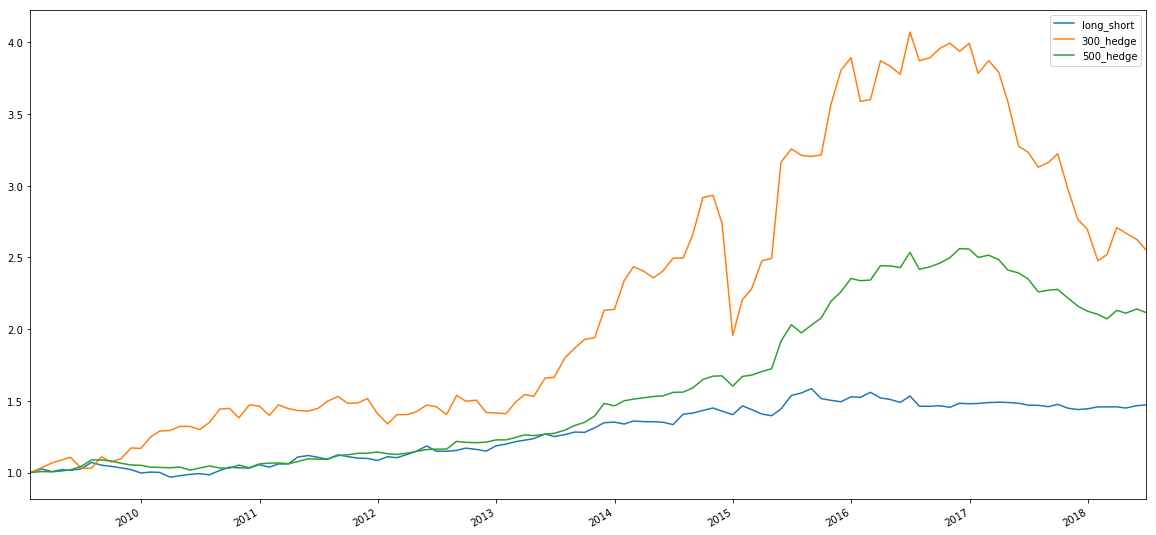

In [178]:
show1(factor_test_obj5)


## Crashp1m10

In [179]:
show2(factor_test_obj10)

,年化收益率,最大回撤,月胜率
long_short,0.032264,0.142986,0.548673
300_hedge,0.098497,0.390543,0.592920
500_hedge,0.075834,0.192887,0.628319


## Crashp1m15

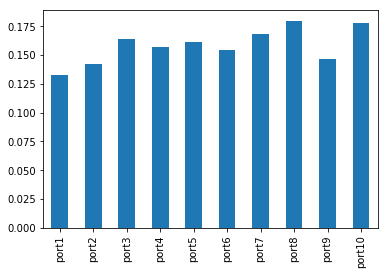

In [173]:
show5(factor_test_obj5j)
# show2(factor_test_obj5j)
# show3(factor_test_obj15)
# show4(factor_test_obj15)
# show5(factor_test_obj15)
# show6(factor_test_obj15)

## Jackpop1m15

In [69]:
# show1(factor_test_obj15j)
show2(factor_test_obj15j)
# show3(factor_test_obj15j)
# show4(factor_test_obj15j)
# show5(factor_test_obj15j)
# show6(factor_test_obj15j)

,年化收益率,最大回撤,月胜率
long_short,0.004811,0.175737,0.522124
300_hedge,0.088945,0.390017,0.566372
500_hedge,0.065707,0.193951,0.654867


## Crashp1m20

In [70]:
# show1(factor_test_obj20)
show2(factor_test_obj20)
# show3(factor_test_obj20)
# show4(factor_test_obj20)
# show5(factor_test_obj20)
# show6(factor_test_obj20)

,年化收益率,最大回撤,月胜率
long_short,-0.010507,0.268728,0.486726
300_hedge,0.076968,0.399749,0.530973
500_hedge,0.054956,0.195789,0.601770


## Jackpop1m20

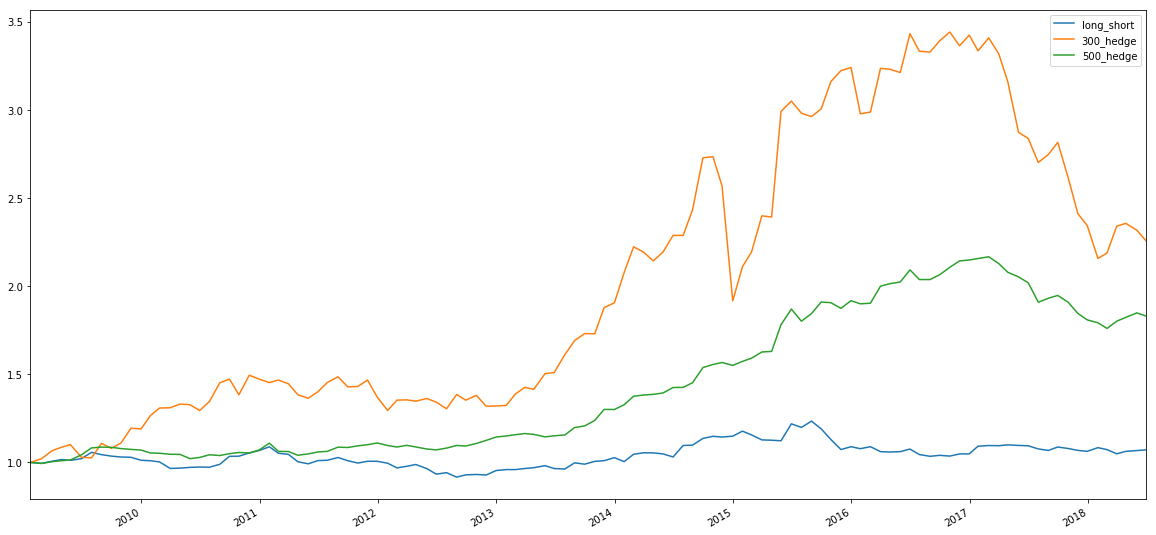

In [176]:
show1(factor_test_obj20j)
# show2(factor_test_obj20j)
# show3(factor_test_obj20j)
# show4(factor_test_obj20j)
# show5(factor_test_obj20j)
# show6(factor_test_obj20j)

## Crashp1m30

In [72]:
# show1(factor_test_obj30)
show2(factor_test_obj30)

,年化收益率,最大回撤,月胜率
long_short,-0.023842,0.284478,0.415929
300_hedge,0.064313,0.406333,0.522124
500_hedge,0.043738,0.211769,0.557522


## Jackpop1m30

In [74]:
# show1(factor_test_obj30j)
show2(factor_test_obj30j)

,年化收益率,最大回撤,月胜率
long_short,0.019214,0.139756,0.566372
300_hedge,0.091827,0.363977,0.610619
500_hedge,0.068359,0.187489,0.663717


## Crashp1m35

In [75]:
# show1(factor_test_obj35)
show2(factor_test_obj35)

,年化收益率,最大回撤,月胜率
long_short,-0.011958,0.249192,0.460177
300_hedge,0.050967,0.407478,0.530973
500_hedge,0.032187,0.214565,0.548673


## Jackpop1m35

In [76]:
# show1(factor_test_obj35j)
show2(factor_test_obj35j)

,年化收益率,最大回撤,月胜率
long_short,0.007229,0.194660,0.548673
300_hedge,0.068007,0.377020,0.592920
500_hedge,0.044013,0.202409,0.628319


## Crashp1m40

In [77]:
# show1(factor_test_obj40)
show2(factor_test_obj35j)

,年化收益率,最大回撤,月胜率
long_short,0.007229,0.194660,0.548673
300_hedge,0.068007,0.377020,0.592920
500_hedge,0.044013,0.202409,0.628319


## Jackpop1m40

In [187]:
# show1(factor_test_obj40j)
show2(factor_test_obj40j)

,年化收益率,最大回撤,月胜率
long_short,-0.002458,0.284017,0.513274
300_hedge,0.071968,0.397045,0.592920
500_hedge,0.048925,0.209591,0.619469
